In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('News.csv',index_col=0)
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [3]:
data = data.drop(["title", "subject","date"], axis = 1)

In [4]:
data.isnull().sum()

text     0
class    0
dtype: int64

In [5]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

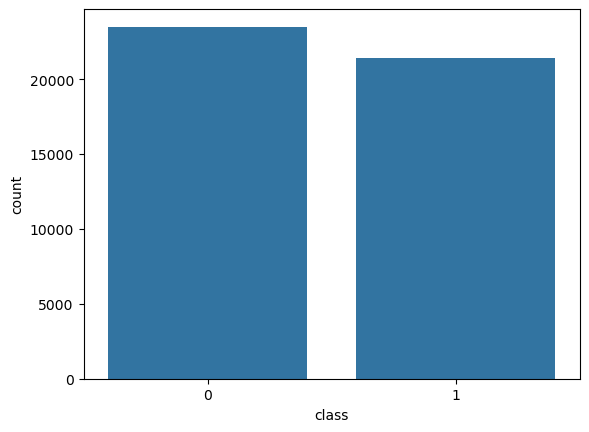

In [6]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [7]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shivensharma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivensharma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text

In [9]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 44919/44919 [09:12<00:00, 81.34it/s] 


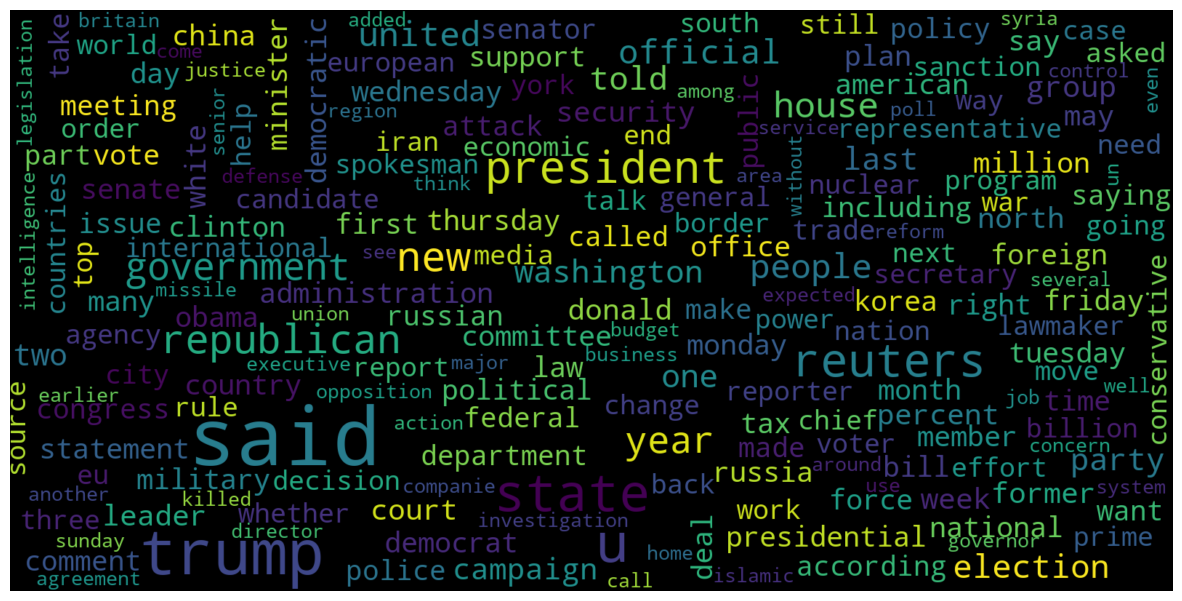

In [10]:
# Real
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

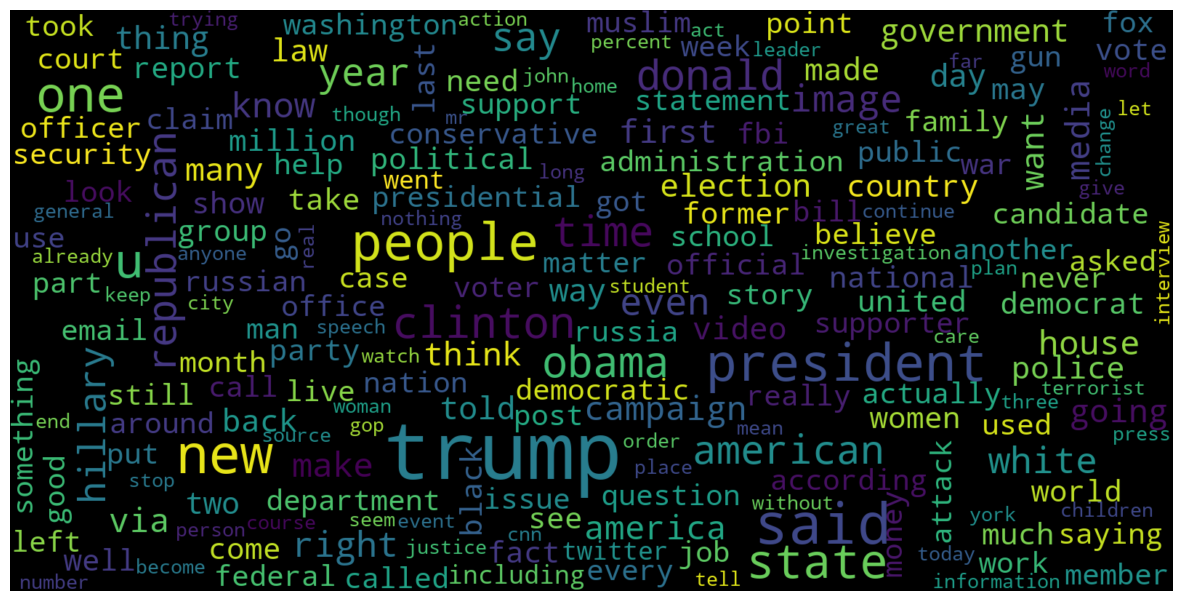

In [11]:
# Fake
consolidated = ' '.join(
	word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

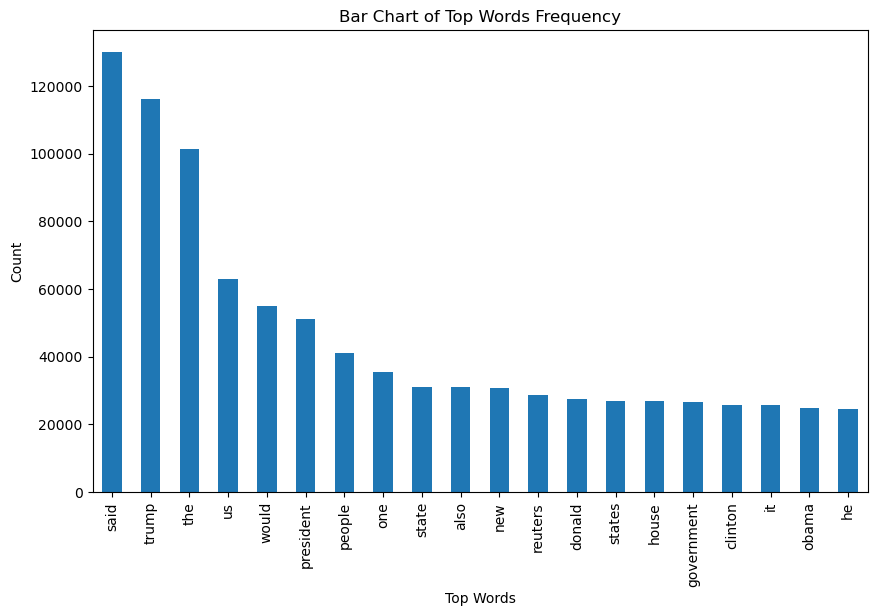

In [12]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
	vec = CountVectorizer().fit(corpus)
	bag_of_words = vec.transform(corpus)
	sum_words = bag_of_words.sum(axis=0)
	words_freq = [(word, sum_words[0, idx])
				for word, idx in vec.vocabulary_.items()]
	words_freq = sorted(words_freq, key=lambda x: x[1],
						reverse=True)
	return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
	kind='bar',
	figsize=(10, 6),
	xlabel="Top Words",
	ylabel="Count",
	title="Bar Chart of Top Words Frequency"
)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
													data['class'],
													test_size=0.25)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

## Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, penalty='l2',solver='liblinear')  # Stronger regularization
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9777078571640595
0.9755120213713268


### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the Decision Tree with cost-complexity pruning
model = DecisionTreeClassifier(ccp_alpha=0.01, max_depth=5, min_samples_split=10)

# Fit the model
model.fit(x_train, y_train)

# Test the model and print accuracy on train and test sets
train_accuracy = accuracy_score(y_train, model.predict(x_train))
test_accuracy = accuracy_score(y_test, model.predict(x_test))

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix and Classification Report for Train set
print("\nConfusion Matrix (Train):")
print(confusion_matrix(y_train, model.predict(x_train)))

print("\nClassification Report (Train):")
print(classification_report(y_train, model.predict(x_train)))

# Confusion Matrix and Classification Report for Test set
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, model.predict(x_test)))

print("\nClassification Report (Test):")
print(classification_report(y_test, model.predict(x_test)))

Training Accuracy: 0.9929056962213185
Test Accuracy: 0.9944790739091719

Confusion Matrix (Train):
[[17368   198]
 [   41 16082]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17566
           1       0.99      1.00      0.99     16123

    accuracy                           0.99     33689
   macro avg       0.99      0.99      0.99     33689
weighted avg       0.99      0.99      0.99     33689


Confusion Matrix (Test):
[[5890   46]
 [  16 5278]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5936
           1       0.99      1.00      0.99      5294

    accuracy                           0.99     11230
   macro avg       0.99      0.99      0.99     11230
weighted avg       0.99      0.99      0.99     11230



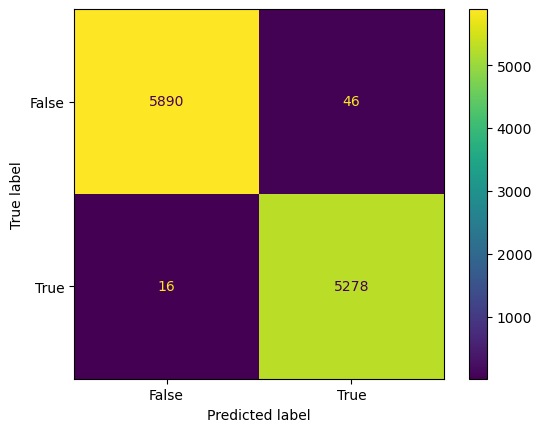

In [19]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Preprocess the text data and split it into training and testing sets
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Random Forest Classifier with optimized parameters
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and accuracy
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9537237674018225
Testing Accuracy: 0.9428317008014248


## Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

# Preprocess the text data and split it into training and testing sets
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['class']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions and accuracy
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9583246757101724
Testing Accuracy: 0.9475512021371327


## BERT Model

In [22]:
import os
import pandas as pd
from transformers import BertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np

# Create the checkpoints directory if it doesn't exist
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

# Load your CSV data
data = pd.read_csv('News.csv', index_col=0)  # Load the dataset
print(data.head())  # Display the first few rows of the dataset

# Assume that 'text' contains the news articles and 'class' contains the labels (adjust as necessary)
X = data['text']  # The text data (news articles)
y = data['class']  # The target labels

# Load DistilBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Transforms class labels into numeric form

# Tokenize the text data with reduced max_length for efficiency
def tokenize_text(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="tf", max_length=128)  # Adjust max_length

# Tokenize and split the data
X_tokenized = tokenize_text(X)  # Tokenize the text data
X_train, X_test, y_train, y_test = train_test_split(X_tokenized['input_ids'].numpy(), y, test_size=0.25, random_state=42)

# Convert labels to TensorFlow tensors
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

# Define optimizer, loss function, and batch size
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Reduced batch size to improve training speed
batch_size = 50

# Training loop with TensorFlow Dataset API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1, restore_best_weights=True
)

# Model training with DistilBERT
distilbert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model with early stopping
distilbert_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=2,  # Set a higher limit since early stopping will terminate earlier if needed
    callbacks=[early_stopping]
)

# Evaluation
loss, accuracy = distilbert_model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  class  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
674/674 [==============================] - 2375s 4s/step - loss: 0.0190 - accuracy: 0.9953 - val_loss: 0.0025 - val_accuracy: 0.9996
Epoch 2/2
674/674 [==============================] - 2331s 3s/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 9.3282e-04 - val_accuracy: 0.9999
Restoring model weights from the end of the best epoch: 2.
225/225 [==============================] - 544s 2s/step - loss: 9.3282e-04 - accuracy: 0.9999
Test Loss: 0.0009328182204626501, Test Accuracy: 0.9999109506607056
